In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pyaccel
import pymodels
# import utils

In [7]:
model = pymodels.si.create_accelerator()
model.cavity_on = False
model.radiation_on = 0
famdata = pymodels.si.get_family_data(model)
famdata['QFA']

{'index': [[18],
  [1294],
  [1318],
  [2594],
  [2616],
  [3902],
  [3926],
  [5212],
  [5237],
  [6522]],
 'subsection': ['01M2',
  '05M1',
  '05M2',
  '09M1',
  '09M2',
  '13M1',
  '13M2',
  '17M1',
  '17M2',
  '01M1'],
 'instance': ['', '', '', '', '', '', '', '', '', ''],
 'devnames': ['SI-01M2:PS-QFA',
  'SI-05M1:PS-QFA',
  'SI-05M2:PS-QFA',
  'SI-09M1:PS-QFA',
  'SI-09M2:PS-QFA',
  'SI-13M1:PS-QFA',
  'SI-13M2:PS-QFA',
  'SI-17M1:PS-QFA',
  'SI-17M2:PS-QFA',
  'SI-01M1:PS-QFA']}

In [ ]:
def add_coupling(model, delta):
    idxs = famdata['QS']['index']
    for idx, nmag in enumerate(idxs):
        if idx == 0:
            dlt = delta/len(nmag)
            for seg in nmag:
                model[seg].KsL += dlt

In [194]:
def calc_coupling(model, x0, nturns=1000):
        coord_ini = np.array([x0, 0, 0, 0, 0, 0])
        coord_fin, *_ = pyaccel.tracking.ring_pass(
            model, coord_ini, nr_turns=nturns,
            turn_by_turn=True, parallel=True)
        rx = coord_fin[0, :]
        ry = coord_fin[2, :]
        twiss, *_ = pyaccel.optics.calc_twiss(model)
        betax, betay = twiss.betax, twiss.betay  # Beta functions
        jx = 1/(betax[0]*nturns)*(np.sum(rx**2))
        jy = 1/(betay[0]*nturns)*(np.sum(ry**2))

        print('emittance ratio = {:.3f}'.format(jy/jx))
        return jy/jx

In [ ]:
def add_delta_quad_fam(model, delta, fam):
    idxs = famdata[fam]['index']
    for idx, nmag in enumerate(idxs):
        dlt = delta/len(nmag)
        for seg in nmag:
            model[seg].KL += dlt

emittance ratio = 0.000
emittance ratio = 0.079
Estimated coupling coefficient = 0.016
Minimum separation = 0.019
0.016153358354474776


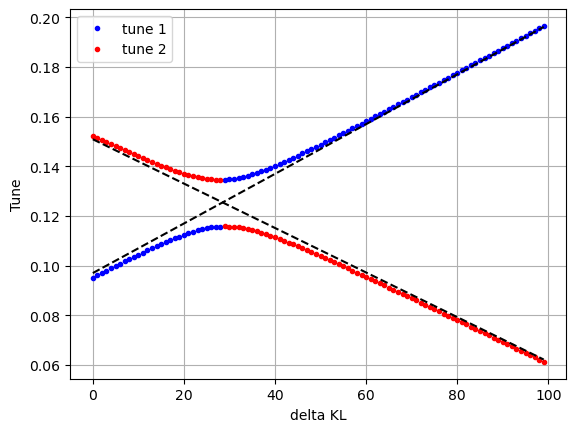

In [204]:
model = pymodels.si.create_accelerator()
model.cavity_on = False
model.radiation_on = 0

twiss, *_ = pyaccel.optics.calc_twiss(model)
nux_ = twiss.mux[-1]/2/np.pi
nuy_ = twiss.muy[-1]/2/np.pi

famdata = pymodels.si.get_family_data(model)

_ = calc_coupling(model, 1e-6)
add_coupling(model, delta=1e-2)
emittance_ratio = calc_coupling(model, 1e-6)

k2 = emittance_ratio*(nux_%1-nuy_%1)**2/(1-emittance_ratio)
print('Estimated coupling coefficient = {:.3f}'.format(np.sqrt(k2)))

nu1 = list()
nu2 = list()
nux = list()
nuy = list()
delta = 0.5e-4
for i in np.linspace(0, 30, 100):
    add_delta_quad_fam(model=model, delta=delta, fam='Q3')
    ed_tang, *_ = pyaccel.optics.calc_edwards_teng(model)
    twiss, *_ = pyaccel.optics.calc_twiss(model)
    nu1_ = ed_tang.mu1[-1]/2/np.pi
    nu2_ = ed_tang.mu2[-1]/2/np.pi
    nux_ = twiss.mux[-1]/2/np.pi
    nuy_ = twiss.muy[-1]/2/np.pi
    nu1.append(nu1_%1)
    nu2.append(nu2_%1)
    nux.append(nux_%1)
    nuy.append(nuy_%1)

plt.plot(nu1, '.', color='b', label='tune 1')
plt.plot(nu2, '.', color='r', label='tune 2')
plt.plot(nux, '--', color='k')
plt.plot(nuy, '--', color='k')
plt.legend()
plt.xlabel('delta KL')
plt.ylabel('Tune')
plt.grid()

min_sep = np.min(np.abs(np.array(nu1)-np.array(nu2)))
print('Minimum separation = {:.3f}'.format(min_sep))
min_tunesep, ratio = pyaccel.optics.estimate_coupling_parameters(ed_tang)
print(min_tunesep)
